In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from time import time

from multi_arm import Arm, k_arm_bandit, epsilon_greedy

#### Set-up True Parameters

In [2]:
ctrs = np.random.normal(0.2, 0.05, 20)
baseline = np.mean(ctrs)
true_winner_idx = np.argmax(ctrs)
print("true_winner_idx:", true_winner_idx)

true_winner_idx: 3


#### Sanity Check

In [3]:
epsilon = 0.2
alpha = 0.05
winner_idx, est_p, wins, traffic, history = epsilon_greedy(ctrs, epsilon)

conversion = 100 * sum(wins) / sum(traffic)
print("good traffic: %i / %i = %.2f%%, baseline %.2f%%"%(sum(wins), 
                                                         sum(traffic), 
                                                         conversion,
                                                         baseline))

Winning arm 3 beats second arm at iteration 101
good traffic: 24 / 121 = 19.83%, baseline 0.21%


In [4]:
winner_idx, est_ps, wins, traffic, history = k_arm_bandit(ctrs)

conversion = 100 * sum(wins) / sum(traffic)
print("good traffic: %i / %i = %.2f%%, baseline %.2f%%"%(sum(wins), 
                                                         sum(traffic), 
                                                         conversion,
                                                         baseline))

Winning arm 9 beats second arm at iteration 2046
good traffic: 606 / 2046 = 29.62%, baseline 0.21%


#### Simulation

In [130]:
cols = ["n_arms", "true_winner_idx", "winner_idx", "true_winner_ctr", "winner_ctr", "traffic", "wins", "baseline"]

ns_arms = list(range(2, 52, 2))
n_trial = 32

In [133]:
start = time()

df_ep = pd.DataFrame(columns=cols)
df_ka = df_ep.copy()

for i, n_arms in enumerate(ns_arms):
    for j in range(n_trial):
        ctrs = np.random.normal(0.2, 0.05, n_arms)
        true_winner_idx = np.argmax(ctrs)
        winner_idx, est_p, wins, traffic, history = epsilon_greedy(ctrs=ctrs, epsilon=0.2, burn_in=1000, silent=True)
        vals = [n_arms, true_winner_idx, winner_idx, ctrs[true_winner_idx], ctrs[winner_idx], sum(traffic), sum(wins), np.mean(ctrs)]
        df_ep = df_ep.append({key : val for key, val in zip(cols, vals)}, ignore_index=True)
        
        winner_idx, est_ps, wins, traffic, history = k_arm_bandit(ctrs=ctrs, burn_in=1000, silent=True)
        vals = [n_arms, true_winner_idx, winner_idx, ctrs[true_winner_idx], ctrs[winner_idx], sum(traffic), sum(wins), np.mean(ctrs)]
        df_ka = df_ka.append({key : val for key, val in zip(cols, vals)}, ignore_index=True)
        
        print("%i arm, trial %i / %i, overall progress: %.2f%%"
              %(n_arms, j, n_trial, 100 * (i * n_trial + j) / (len(ns_arms) * n_trial)) , end='\r')
        
df_ep["conversion"] = df_ep.wins / df_ep.traffic
df_ka["conversion"] = df_ka.wins / df_ka.traffic

df_ep.to_csv("outputs/df_ep_%i-%i_arms.csv"%(ns_arms[0], ns_arms[-1]), index=None)
df_ka.to_csv("outputs/df_ka_%i-%i_arms.csv"%(ns_arms[0], ns_arms[-1]), index=None)

end = time()
print("\ntime elapsed: %.2fs"%(end - start))

time elapsed: 10828.48soverall progress: 99.88%


In [135]:
df_ep.head()

,n_arms,true_winner_idx,winner_idx,traffic,wins,baseline,conversion
0,2.0,1.0,1.0,1003.0,207.0,0.201026,0.206381
1,2.0,1.0,1.0,1003.0,164.0,0.144264,0.163509
2,2.0,1.0,1.0,1003.0,301.0,0.233327,0.300100
3,2.0,0.0,0.0,1003.0,201.0,0.201328,0.200399
4,2.0,0.0,0.0,26933.0,4086.0,0.149353,0.151710


#### Analyze Results

In [210]:
df_ep = pd.read_csv("outputs/df_ep_%i-%i_arms.csv"%(ns_arms[0], ns_arms[-1]))
df_ka = pd.read_csv("outputs/df_ka_%i-%i_arms.csv"%(ns_arms[0], ns_arms[-1]))
df_ep.head()

,n_arms,true_winner_idx,winner_idx,traffic,wins,baseline,conversion
0,2.0,1.0,1.0,1003.0,207.0,0.201026,0.206381
1,2.0,1.0,1.0,1003.0,164.0,0.144264,0.163509
2,2.0,1.0,1.0,1003.0,301.0,0.233327,0.300100
3,2.0,0.0,0.0,1003.0,201.0,0.201328,0.200399
4,2.0,0.0,0.0,26933.0,4086.0,0.149353,0.151710


In [211]:
import pandasql

q = """
SELECT 
    n_arms
    ,AVG(wins) AS wins
    ,AVG(traffic) AS traffic
    ,AVG(conversion) AS conversion
    ,AVG(baseline) AS baseline
    ,SUM(CASE WHEN true_winner_idx = winner_idx THEN 1 ELSE 0 END) AS success
FROM %s
GROUP BY n_arms
"""

In [212]:
df_ep_agg = pandasql.sqldf(q.lower()%"df_ep", locals())
df_ep_agg["success_prob"] = df_ep_agg["success"] / n_trial
df_ep_agg.head()

,n_arms,wins,wins_s,traffic,conversion,baseline,success,success_prob
0,2.0,1400.00000,204.0,6689.28125,0.219954,0.208801,32,1.00000
1,4.0,3779.90625,1228.0,16296.59375,0.233109,0.203625,31,0.96875
2,6.0,3553.56250,203.0,14301.68750,0.247877,0.202544,29,0.90625
3,8.0,8401.90625,2082.0,34435.68750,0.248823,0.202537,29,0.90625
4,10.0,8963.68750,12656.0,36535.56250,0.250649,0.200591,26,0.81250


In [213]:
df_ka_agg = pandasql.sqldf(q.lower()%"df_ka", locals())
df_ka_agg["success_prob"] = df_ka_agg["success"] / n_trial
df_ka_agg.head()

,n_arms,wins,wins_s,traffic,conversion,baseline,success,success_prob
0,2.0,1426.50000,498.0,6247.21875,0.229505,0.208801,23,0.71875
1,4.0,2451.46875,467.0,11623.18750,0.240454,0.203625,27,0.84375
2,6.0,3311.18750,5007.0,13002.34375,0.253725,0.202544,28,0.87500
3,8.0,4380.46875,575.0,17889.00000,0.251014,0.202537,24,0.75000
4,10.0,4639.59375,21701.0,18715.68750,0.253808,0.200591,26,0.81250


In [214]:
df_ep_std = df_ep[["n_arms", "traffic", "wins", "conversion"]].groupby('n_arms').std()
df_ka_std = df_ka[["n_arms", "traffic", "wins", "conversion"]].groupby('n_arms').std()

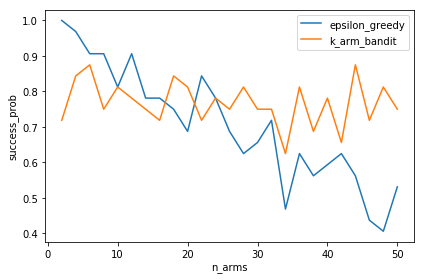

In [215]:
plt.plot(df_ep_agg.n_arms, df_ep_agg.success_prob)
plt.plot(df_ka_agg.n_arms, df_ka_agg.success_prob)

plt.xlabel("n_arms")
plt.ylabel("success_prob")

plt.legend(["epsilon_greedy", "k_arm_bandit"])

plt.tight_layout()

plt.savefig('outputs/compare_ep_ka_%i-%i_arms_success_prob.png'%(ns_arms[0], ns_arms[-1]))

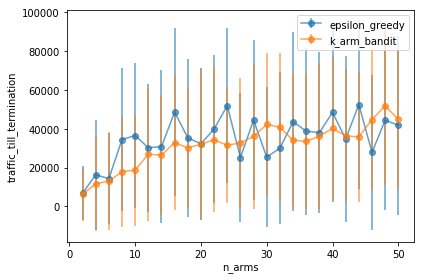

In [216]:
# no error bar
# plt.plot(df_ep_agg.n_arms, df_ep_agg.traffic)
# plt.plot(df_ka_agg.n_arms, df_ka_agg.traffic)

# add error bar
plt.errorbar(df_ep_agg.n_arms, df_ep_agg.traffic, df_ep_std.traffic, linestyle='-', marker='o', alpha=0.7)
plt.errorbar(df_ka_agg.n_arms, df_ka_agg.traffic, df_ka_std.traffic, linestyle='-', marker='o', alpha=0.7)

plt.xlabel("n_arms")
plt.ylabel("traffic_till_termination")

plt.legend(["epsilon_greedy", "k_arm_bandit"])

plt.tight_layout()

plt.savefig('outputs/compare_ep_ka_%i-%i_arms_traffic.png'%(ns_arms[0], ns_arms[-1]))

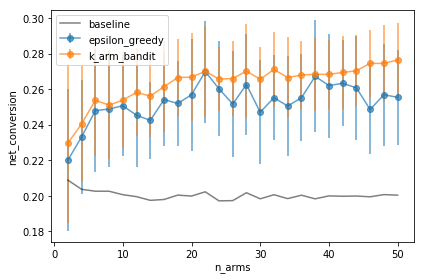

In [217]:
# no error bar
# plt.plot(df_ep_agg.n_arms, df_ep_agg.conversion)
# plt.plot(df_ka_agg.n_arms, df_ka_agg.conversion)

# add error bar
plt.plot(df_ka_agg.n_arms, df_ep_agg.baseline, color='black', alpha=0.5)
plt.errorbar(df_ep_agg.n_arms, df_ep_agg.conversion, df_ep_std.conversion, linestyle='-', marker='o', alpha=0.7)
plt.errorbar(df_ka_agg.n_arms, df_ka_agg.conversion, df_ka_std.conversion, linestyle='-', marker='o', alpha=0.7)

plt.xlabel("n_arms")
plt.ylabel("net_conversion")

plt.legend(["baseline", "epsilon_greedy", "k_arm_bandit"])

plt.tight_layout()

plt.savefig('outputs/compare_ep_ka_%i-%i_arms_conversion.png'%(ns_arms[0], ns_arms[-1]))

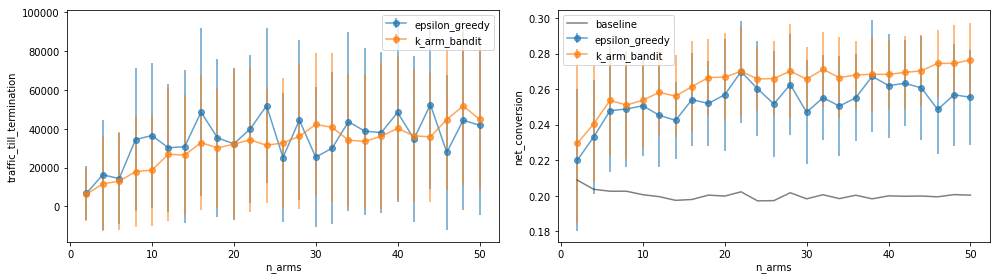

In [218]:
plt.figure(figsize=(14, 4))

ax1 = plt.subplot(1, 2, 1)
ax1.errorbar(df_ep_agg.n_arms, df_ep_agg.traffic, df_ep_std.traffic, linestyle='-', marker='o', alpha=0.7)
ax1.errorbar(df_ka_agg.n_arms, df_ka_agg.traffic, df_ka_std.traffic, linestyle='-', marker='o', alpha=0.7)

ax1.set_xlabel("n_arms")
ax1.set_ylabel("traffic_till_termination")
ax1.legend(["epsilon_greedy", "k_arm_bandit"])

ax2 = plt.subplot(1, 2, 2)
ax2.plot(df_ka_agg.n_arms, df_ep_agg.baseline, color='black', alpha=0.5)
ax2.errorbar(df_ep_agg.n_arms, df_ep_agg.conversion, df_ep_std.conversion, linestyle='-', marker='o', alpha=0.7)
ax2.errorbar(df_ka_agg.n_arms, df_ka_agg.conversion, df_ka_std.conversion, linestyle='-', marker='o', alpha=0.7)

ax2.set_xlabel("n_arms")
ax2.set_ylabel("net_conversion")
ax2.legend(["baseline", "epsilon_greedy", "k_arm_bandit"])

plt.tight_layout()

plt.savefig('outputs/compare_ep_ka_%i-%i_arms_combined.png'%(ns_arms[0], ns_arms[-1]))